# Visualise dataset, Normalise Images, Save as .npy

### For Colab Start Here

In [70]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Mask-Or-No-Mask'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

### For PyCharm Start Here

In [86]:
import random
import matplotlib.pyplot as plt
from collections import Counter
from skimage.feature import hog
from Preprocess import *
from Feature_Extraction import load_features


### Make sure to comment out the Paths depending on IDE (PyCharm or Colab)

In [78]:

# Path to images and labels
# -------------------------- Paths for PyCharm --------------------------

DATASET_PATH = "../CW_Dataset"
TRAIN_IMAGE_PATH = "../CW_Dataset/train/images"
TRAIN_LABEL_PATH = "../CW_Dataset/train/labels"
TEST_IMAGE_PATH = "../CW_Dataset/test/images"
TEST_LABEL_PATH = "../CW_Dataset/test/labels"
TRAIN_FLOAT32_PATH = "../dataset_as_pkl/normalized_float32_train.pkl"
TEST_FLOAT32_PATH = "../dataset_as_pkl/normalized_float32_test.pkl"
TRAIN_UINT8_PATH = "../dataset_as_pkl/normalized_uint8_train.pkl"
TEST_UINT8_PATH = "../dataset_as_pkl/normalized_uint8_test.pkl"
HOG_PATH = "../dataset_as_pkl/hog_train.pkl"
SIFT_PATH = "../dataset_as_pkl/sift_train.pkl"
ORB_PATH = "../dataset_as_pkl/orb_train.pkl"

# -------------------------- Paths for PyCharm --------------------------

# -------------------------- Paths for Colab --------------------------

# DATASET_PATH = "/content/drive/MyDrive/Mask-Or-No-Mask/CW_Dataset"
# TRAIN_IMAGE_PATH = f"{DATASET_PATH}/train/images"
# TRAIN_LABEL_PATH = f"{DATASET_PATH}/train/labels"
# TEST_IMAGE_PATH = f"{DATASET_PATH}/test/images"
# TEST_LABEL_PATH = f"{DATASET_PATH}/test/labels"
# TRAIN_FLOAT32_PATH = f"{DATASET_PATH}/../dataset_as_pkl/normalized_float32_train.pkl"
# TEST_FLOAT32_PATH = f"{DATASET_PATH}/../dataset_as_pkl/normalized_float32_test.pkl"
# TRAIN_UINT8_PATH = f"{DATASET_PATH}/../dataset_as_pkl/normalized_uint8_train.pkl"
# TEST_UINT8_PATH = f"{DATASET_PATH}/../dataset_as_pkl/normalized_uint8_test.pkl"

# -------------------------- Paths for Colab --------------------------


# Displaying 6 random images from dataset to see what we are working with

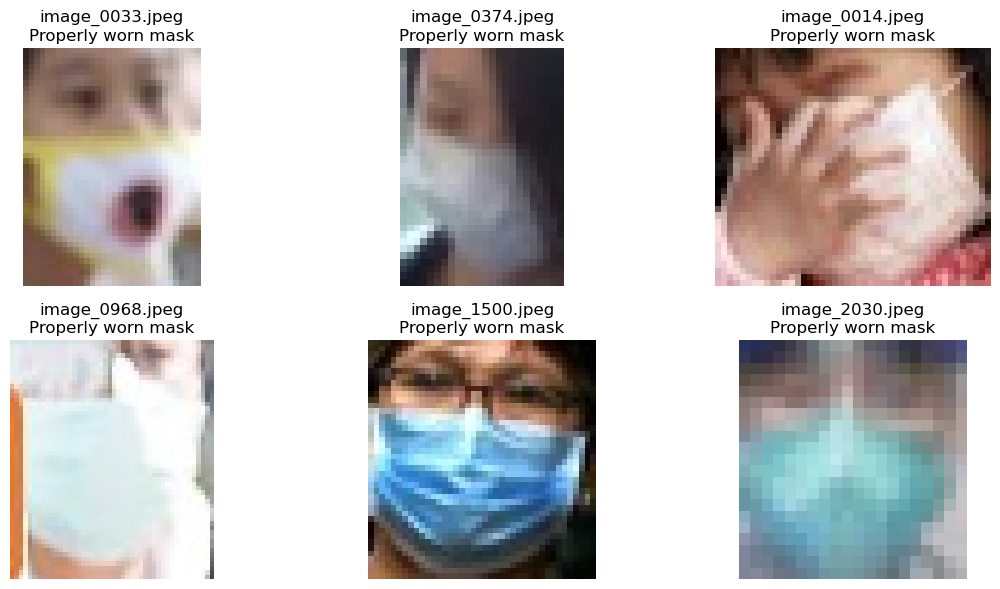

In [79]:
def show_random_images(ip, lp):
    # Map to associate value with category
    label_map = {
        '0': "No mask",
        '1': "Properly worn mask",
        '2': "Improperly worn mask"
    }

    # Get all images
    image_files = [f for f in os.listdir(ip) if f.lower().endswith('.jpeg')]

    # Select random images
    num_samples = 6
    sampled_images = random.sample(image_files, num_samples)

    # Plot
    plt.figure(figsize=(12, 6))
    for i, img_name in enumerate(sampled_images):
        img_path = os.path.join(ip, img_name)

        # Read image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to RGB for matplotlib

        # Find label for image
        label_filename = os.path.splitext(img_name)[0] + '.txt'
        label_path = os.path.join(lp, label_filename)

        # Read label
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label_index = f.read().strip()
            label_text = label_map.get(label_index, "Unknown label")
        else:
            label_text = 'Unknown label'

        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(f"{img_name}\n{label_text}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_random_images(TRAIN_IMAGE_PATH, TRAIN_LABEL_PATH)

- Initially thought of using padding to make all images the same size
- Realised this might cause issues with edge detection, because of the sharp border of the black/white pixels I will be adding
	- This could cause big issues down the line with feature descriptors
- Thought about adding padding then using a pre-trained face detection model to crop into the faces and pull a consistent size
- Realised, if I'm using face detection, then why bother adding padding as the face detection should only pull the face regardless of image size.
- Options
	- OpenCV Haar Cascade Classifier
	- OpenCV DNN Face Detection
	- dlib.get_frontal_face()
- Decided on using OpenCVs DNN Face Detection model
- Learnt that that model needs images of at least 100x100 to be nicely accurate
- Realised, that due to the vast different in the sizes of the images even if the image size wasn't an issue, the face detection model would probably poorly handle up/downscaling of the images

- Going to write code to allow me to find the frequency of the sizes of the images and visualise them, that way I can choose the best size to normalise too. I.e.
	- Most images are in the range 10x10 - 70x70 then 64x64 seems fitting
	- Most images are in the range 100x100 - 150x150 then 128x128 seems fitting


# Visualizing spread of image sizes

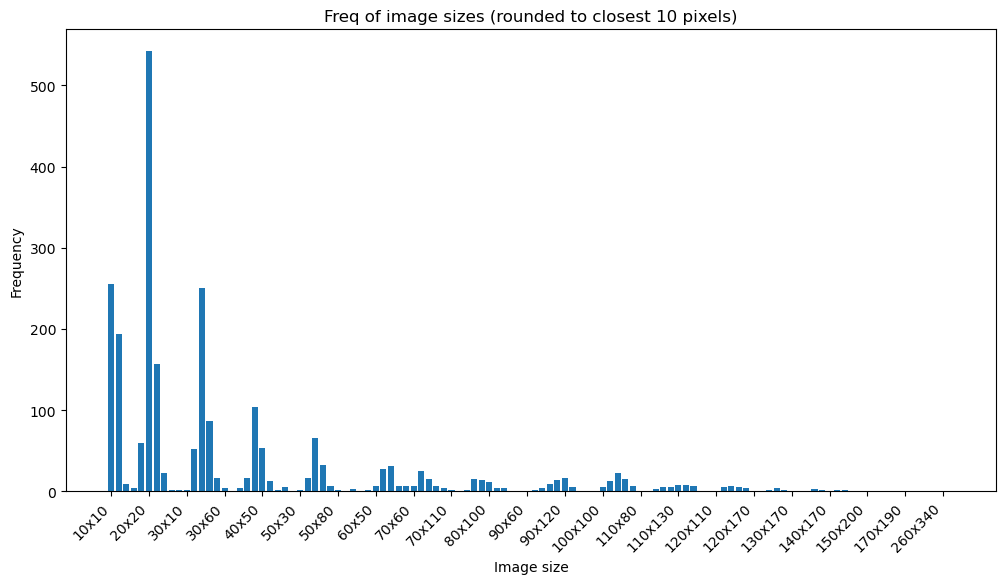

In [80]:
image_sizes = []

for filename in os.listdir(TRAIN_IMAGE_PATH):
    if filename.lower().endswith('.jpeg'):
        img_path = os.path.join(TRAIN_IMAGE_PATH, filename)
        img = cv2.imread(img_path)

        if img is not None:
            h, w = img.shape[:2]
            rounded_sizes = (w // 10 * 10, h // 10 * 10)
            image_sizes.append(rounded_sizes)

counter = Counter(image_sizes)

sorted_sizes = sorted(counter.items(), key=lambda x: (x[0][0], x[0][1]))
labels = [f"{w}x{h}" for (w, h), _ in sorted_sizes]
counts = [count for _, count in sorted_sizes]

skip = 5

plt.figure(figsize=(12, 6))
plt.bar(labels, counts)
plt.xticks(ticks = range(0, len(labels), skip), labels = labels[::skip], rotation = 45, ha = 'right')
plt.title('Freq of image sizes (rounded to closest 10 pixels)')
plt.xlabel('Image size')
plt.ylabel('Frequency')
plt.show()


- Based on the results from the visualisation I can see that most of the images are on the smaller side therefore I will go 64x64.
	- I questioned whether I should choose a rectangular size rather than square but upon research learned that
	    - 64x64 is somewhat of a standard
	    - It is best for model compatibility
	    - Allows for uniform cell layout for HOG descriptors
	    - can easily augment the image (flip/rotate)
	    - etc.

- Adding padding to the image
    - Maintaining aspect ratio
    - Centering image
    - Padding colour will be black

- Loading normalized images
    - Make images greyscale
    - Normalize pixel values
    - Save all the images as np.array so I don't have to do this every time
    - Add the images and labels to lists for ease of use



# Select path

In [81]:
def select_path(dataset_name="train", data_type="float32"):
    # Choose paths based on train or test data
    if dataset_name == "train" and data_type == "float32":
        chosen_path = load_features(TRAIN_FLOAT32_PATH)
    elif dataset_name == "train" and data_type == "uint8":
        chosen_path = load_features(TRAIN_UINT8_PATH)
    elif dataset_name == "test" and data_type == "float32":
        chosen_path = load_features(TEST_FLOAT32_PATH)
    elif dataset_name == "test" and data_type == "uint8":
        chosen_path = load_features(TEST_UINT8_PATH)
    else:
        raise ValueError("dataset_name must be 'train' or 'test'")

    return chosen_path

# Display 6 random normalized images from .pkl

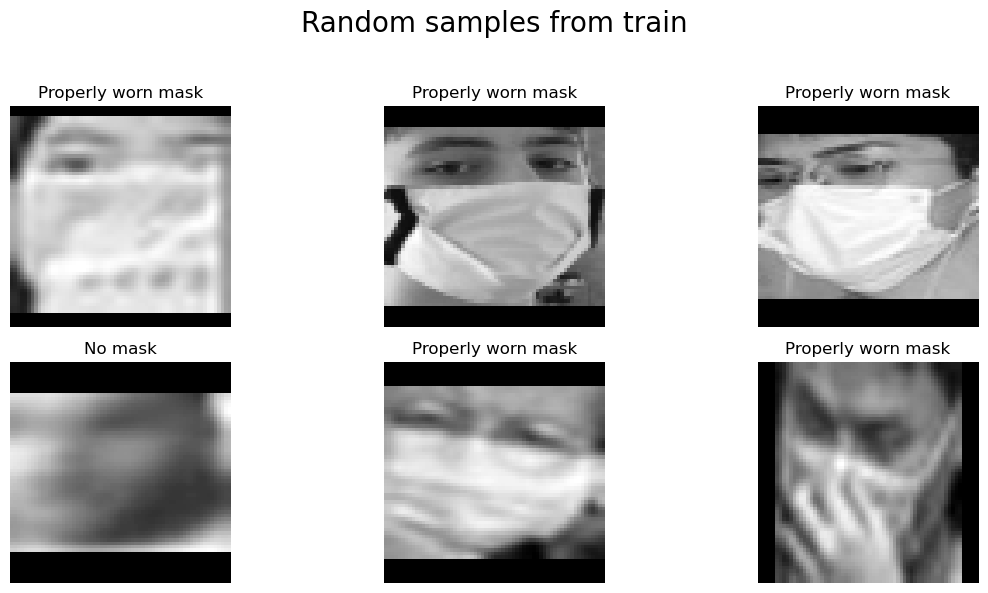

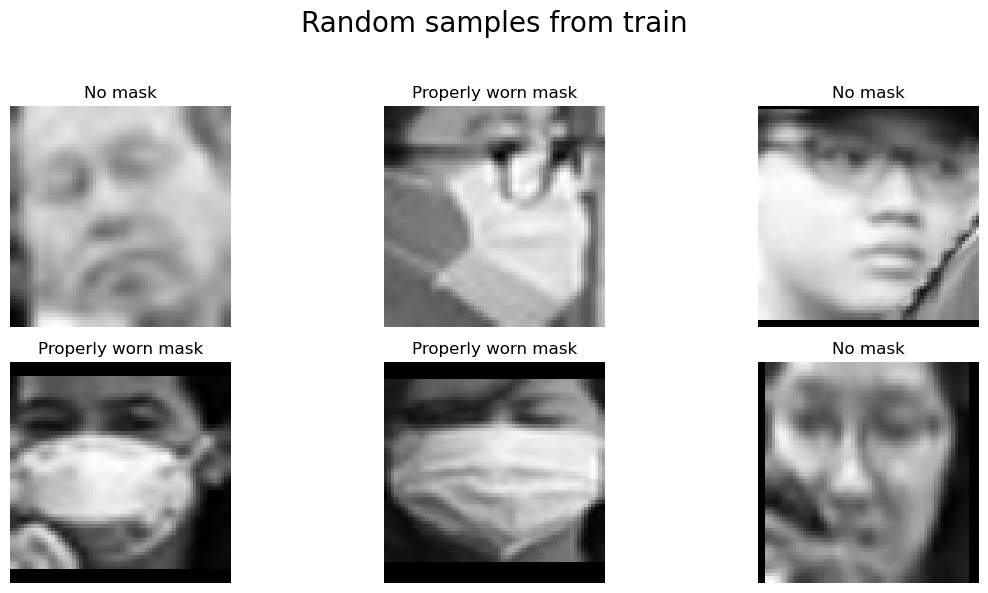

In [82]:

def show_random_normalized_images(label_map=None, num_samples=6, dataset_name="train", data_type="float32"):
    X, y = select_path(dataset_name, data_type)

    # Match the labels with the correct categories
    if label_map is None:
        label_map = {
            0: "No mask",
            1: "Properly worn mask",
            2: "Improperly worn mask"
        }

    # Randomly select the images from the dataset
    indices = random.sample(range(len(X)), num_samples)

    # Create the grid to display images
    plt.figure(figsize=(12, 6))
    plt.suptitle(f'Random samples from {dataset_name}', fontsize=20)

    for i, idx in enumerate(indices):
        img = X[idx]
        label = y[idx]
        label_text = label_map.get(label, "Unknown")

        if img.ndim == 3 and img.shape[-1] == 1:
            img = img.squeeze()

        plt.subplot(2, 3, i + 1)
        plt.gca().set_facecolor('white')
        plt.imshow(img, cmap='gray')
        plt.title(label_text)
        plt.axis('off')

    plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.95))
    plt.show()

show_random_normalized_images(dataset_name="train", data_type="uint8")
show_random_normalized_images(dataset_name="train", data_type="float32")

# Visualising HOG features

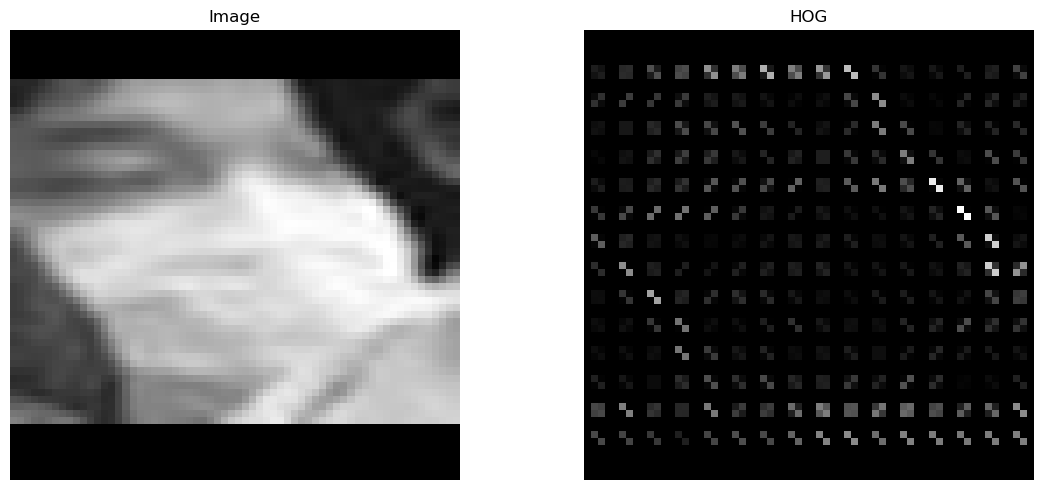

In [83]:
def visualize_hog(image):
    # Compute HOG descriptor (feature vector)
    hog_descriptor, hog_image = hog(
        image,
        orientations = 8,
        pixels_per_cell = (4, 4),
        cells_per_block = (2, 2),
        block_norm = "L2-Hys",
        visualize = True
    )

    # Plot image and HOG
    plt.figure(figsize = (12, 5))

    # Image
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Image')
    plt.axis('off')

    # HOG
    plt.subplot(1, 2, 2)
    plt.imshow(hog_image, cmap = 'gray')
    plt.title("HOG")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

X, y = load_features(TRAIN_FLOAT32_PATH)
sample_image = random.choice(X)
visualize_hog(sample_image)

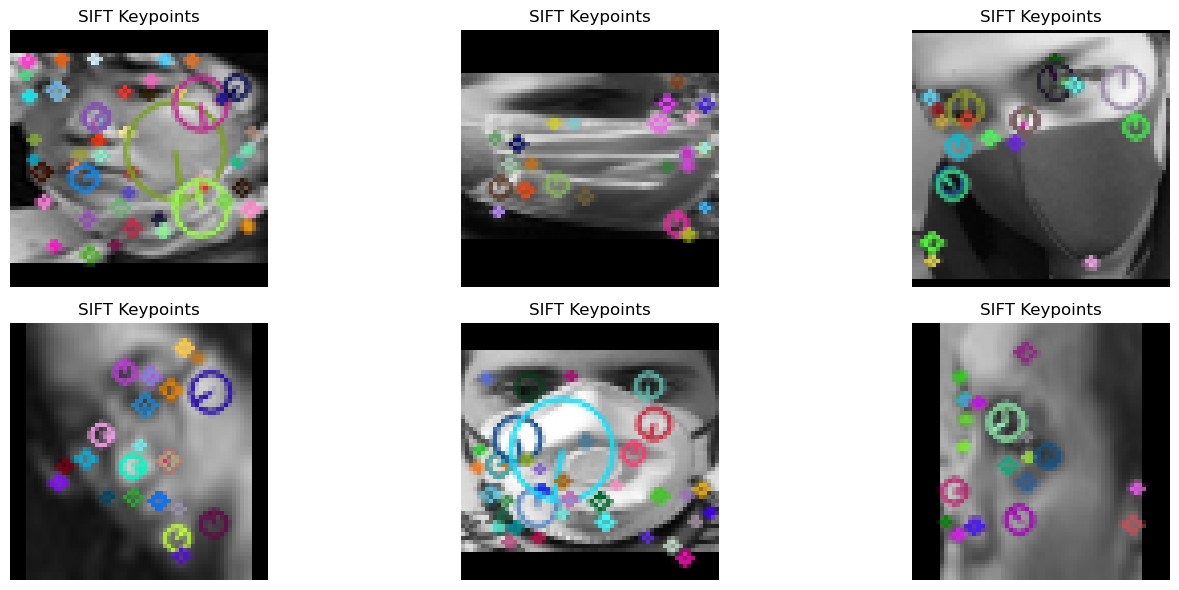

In [84]:
def visualize_sift(dataset="train", num_samples=6):
    if dataset == "train":
        X, y = load_features(TRAIN_UINT8_PATH)
    elif dataset == "test":
        X, y = load_features(TEST_UINT8_PATH)
    else:
        raise ValueError("dataset must be 'train' or 'test'")

    sift = cv2.SIFT_create()
    indices = random.sample(range(len(X)), min(num_samples, len(X)))

    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(indices):
        img = X[idx]
        kp, _ = sift.detectAndCompute(img, None)
        img_with_kp = cv2.drawKeypoints(img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

        plt.subplot(2, 3, i + 1)
        plt.imshow(img_with_kp, cmap='gray')
        plt.title("SIFT Keypoints")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_sift("train")

[0] ORB keypoints: 0
[1] ORB keypoints: 1
[2] ORB keypoints: 0
[3] ORB keypoints: 0
[4] ORB keypoints: 0
[5] ORB keypoints: 1


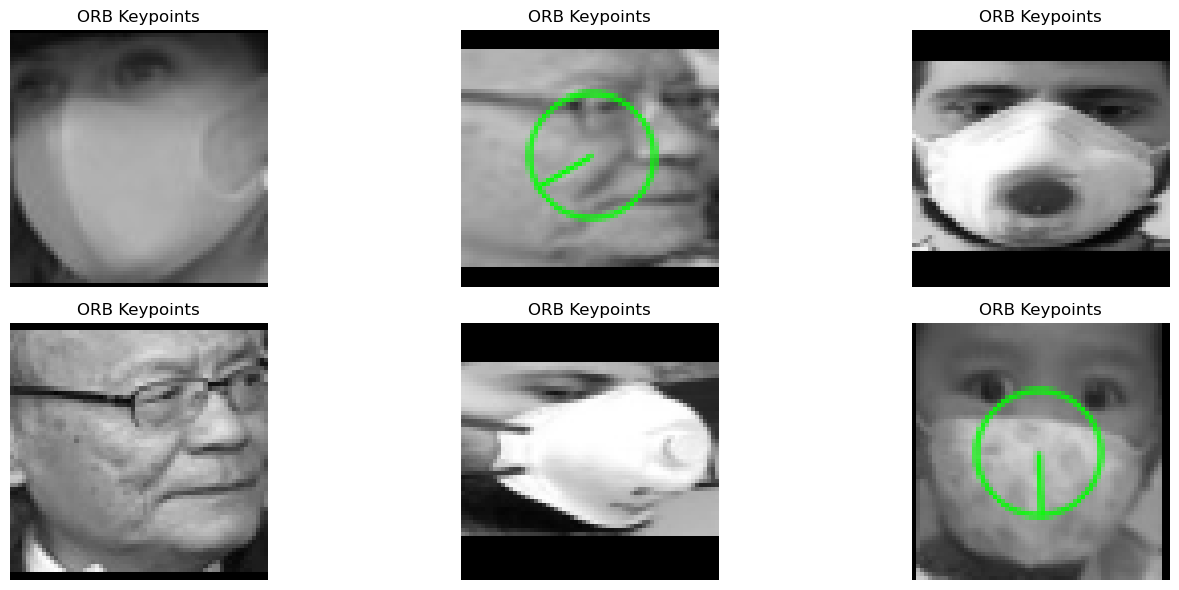

In [88]:
def visualize_orb(dataset="train", num_samples=6):
    if dataset == "train":
        X, y = load_features(TRAIN_UINT8_PATH)
    elif dataset == "test":
        X, y = load_features(TEST_UINT8_PATH)
    else:
        raise ValueError("dataset must be 'train' or 'test'")

    orb = cv2.ORB_create(nfeatures=1000, fastThreshold=5)
    indices = random.sample(range(len(X)), min(num_samples, len(X)))

    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(indices):
        img = X[idx]
        kp, _ = orb.detectAndCompute(img, None)
        print(f"[{i}] ORB keypoints: {len(kp)}")
        img_with_kp = cv2.drawKeypoints(img, kp, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

        plt.subplot(2, 3, i + 1)
        plt.imshow(img_with_kp, cmap='gray')
        plt.title("ORB Keypoints")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
visualize_orb("train")